# Optimizing hyperparameters with Pipelines and Gridsearch

When training machine learning models, usually there are certain model parameters which need to be chosen. Some examples are:

- **Random Forest**: The max depth of the trees, splitting parameters, max features per tree, etc
- **Logistic Regression**: Penalty function, stopping criteria, regularization strength
- **Neural Network**: Activation functions, learning rate, gradient descent algorithm
- **Tokenizing**: Filter out frequent words, unigrams vs bigrams vs trigrams, etc...

> Note that parameters in the feature preparation step should also included in the hyperparameters, as these also can have a big influence on the accuracy of our model.

Almost every machine learning model has so-called hyperparameters which need to be chosen. Often default values are given in ML frameworks like scikit-learn, but if we do some optimization we can probably improve our model performance by tweaking these values.

## Geometric interpretation

So how are we going to find these parameters? What problem are we trying to solve?

> Given the test/training data, find the hyperparameters that minimize the model error (classification/regression) on the test data

If we consider a problem with two hyperparameters, we can actually plot this as a function:

![](uneven_field.png)

Here the (x,y) points are combinations of our two hyperparameters, and the z:=f(x,y) is the error on the training data. Often our hyperparameter-space will be of much higher dimensions, but that becomes more difficult to visualize.

## Grid Search

There are many approaches to tuning these hyperparameters (a whole [field of mathematics](https://en.wikipedia.org/wiki/Mathematical_optimization?oldformat=true) is focused on creating such algorithms!), the simplest one is the gridsearch. 

We split the parameters space into an evenly defined grid like this:

![](https://cdn-images-1.medium.com/max/800/1*fOCJ_mAi_-MNb7dfrXjW5A.gif)

We then calculate the error for each gridpoint, and hope we didn't miss much in the points we didn't calculate. We then choose the best one as our optimum.

Here's [a fun article](https://medium.com/rants-on-machine-learning/smarter-parameter-sweeps-or-why-grid-search-is-plain-stupid-c17d97a0e881) about why there are much better techniques than grid search, for the curious reader.

> **Note**: There are smarter ways of doing such a search (like stochastic gradient descent) but these need some information about the slope of the error function at the point you're evaluating it. In some situations this is possible, but often won't be.

## Implementation in scikit-learn

For implementation, we're going to use a simple text classification problem. We'll put the entire model (from data to score) into a **`Pipeline`** object so that we can easily pass it to a **`GridSearchCV`** function which will do the searching for us.

There are two classes which are used to create machine-learning models in scikit-learn:
- Transformers: These have a fit and transform method.
- Estimators: These have a fit and predict method.

When creating a ML model, you use **multiple transformers** (for feature extraction, text preprocessing, post processing of scores) together with **one estimator**.

The pipeline class can be used to combines all these seperate steps into one new estimator, which we can then do cool stuff with.

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import LogisticRegression

news = fetch_20newsgroups()

In [10]:
parameters = {
    'hashing__n_features': [2**n for n in range(12,15)],
    'hashing__ngram_range': [(1,1), (1,2), (1,3)]
}

pipeline = Pipeline([
    ('hashing', HashingVectorizer(strip_accents='ascii',
                                  analyzer='word',
                                  stop_words='english')),
    ('logres', LogisticRegression())
])

clf = GridSearchCV(estimator = pipeline, 
                   param_grid = parameters, 
                   scoring = 'accuracy',
                   n_jobs=-1)

In [11]:
clf.fit(news.data, news.target)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('hashing', HashingVectorizer(alternate_sign=True, analyzer='word', binary=False,
         decode_error='strict', dtype=<class 'numpy.float64'>,
         encoding='utf-8', input='content', lowercase=True,
         n_features=1048576, ngram_range=(1, 1), non_negative=False,
         norm='l2',...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'hashing__n_features': [4096, 8192, 16384], 'hashing__ngram_range': [(1, 1), (1, 2), (1, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [16]:
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)

Pipeline(memory=None,
     steps=[('hashing', HashingVectorizer(alternate_sign=True, analyzer='word', binary=False,
         decode_error='strict', dtype=<class 'numpy.float64'>,
         encoding='utf-8', input='content', lowercase=True,
         n_features=16384, ngram_range=(1, 1), non_negative=False,
         norm='l2', p...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
{'hashing__n_features': 16384, 'hashing__ngram_range': (1, 1)}
0.839667668375464


Great! It looks like our gridsearch was succesfull. Lets have a look at what the outcome was. We can do this by looking at the **`mean_test_score`** and the corresponding **`params`** lists in the **`cv_results_`** attribute:

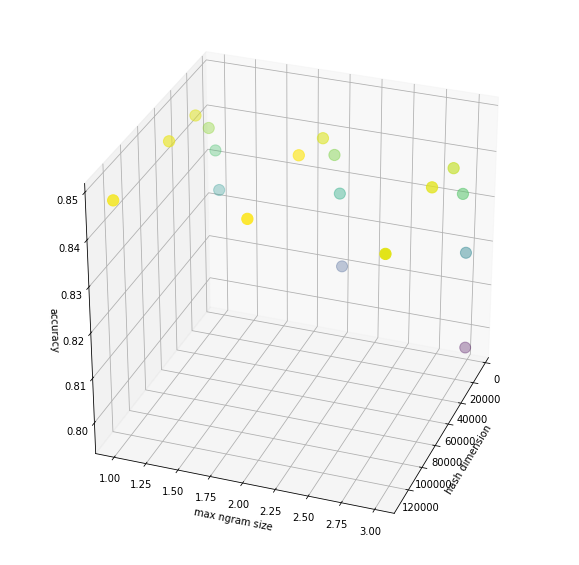

In [34]:
score = clf.cv_results_['mean_test_score']
features = [[par['hashing__n_features'], par['hashing__ngram_range'][1]] 
                for par in clf.cv_results_['params']]

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter([x[0] for x in features], [x[1] for x in features], score, c = score, s = score*150)

ax.set_xlabel('hash dimension')
ax.set_ylabel('max ngram size')
ax.set_zlabel('accuracy')

matplotlib.rcParams.update({'figure.figsize':[10,10]})

ax.view_init(30, 20)
plt.draw()
plt.pause(.001)

plt.show()

# TL;DR

- Use hyperparameter optimization to improve parameters not learned during model training
- `Pipeline` + `GridSearchCV` in scikit-learn can make this a lot easier
- Watch out that you don't overfit your hyperparameters to the test data!

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin

class LowerCasing(BaseEstimator, TransformerMixin):
    """Lower case list of strings"""
        
    def fit(self, X):
        return self
        
    def transform(self, X):
        return [doc.lower() for doc in X]

In [31]:
X = ["Hello there!", "KLSDJFLSDKF", "3423524522"]
lowercasing = LowerCasing()

In [33]:
lowercasing.transform(X)
lowercasing.

['hello there!', 'klsdjflsdkf', '3423524522']

In [39]:
pipeline = Pipeline([
    ('lowercase', LowerCasing()),
    ('hashing', HashingVectorizer(strip_accents='ascii',
                                  analyzer='word',
                                  stop_words='english')),
    ('logres', LogisticRegression())
])

news.target.shape

(11314,)